<div dir="rtl" lang="he" xml:lang="he">

# שכבת Embedding Layer 
שכבת הטמעה לוקחת יצוג של מילה שהוא מספר בודד ומציגה אותו כוקטור מספרים. 
יצוג מאפשר למפות מילים למספרים בצורה יותר חכמה, לדוגמה, מילים דומות יכולות להיות קרובות מבחינה וקטורית

נדמיין שני אנשים, יוסי ונעם (בלי ו)
לכל אחד מהם נסמן סט של קטגוריות כמותיות ונמלא על כל אחד. 

In [40]:
import torch
from torchtext import vocab
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
sentence_1 = "הוא הלך לפארק"
sentence_2 = "הם נסעו לבית"
sentence_3 = "אבא ילך לחנות"
sentence_4 = "היא הגיעה לבית-ספר"
sentences = [sentence_1, sentence_2, sentence_3, sentence_4]
words = " ".join(sentences).split()
dictionary = vocab.vocab({words[i]:i+1 for i in range(len(words))})
dictionary.set_default_index(0)


In [41]:
print(dictionary(sentence_1.split()))
print(dictionary(sentence_4.split()))

[0, 1, 2]
[9, 10, 11]


In [42]:
embedding = torch.nn.Embedding(len(words),2)
senten_as_num = torch.tensor(dictionary(sentence_1.split()))
senten_as_vecotr = embedding(senten_as_num)
print(f"""
{senten_as_num=},
{senten_as_vecotr=}
""")


senten_as_num=tensor([0, 1, 2]),
senten_as_vecotr=tensor([[ 0.8177,  2.3785],
        [ 1.1748, -2.0294],
        [-0.3574,  1.6845]], grad_fn=<EmbeddingBackward0>)



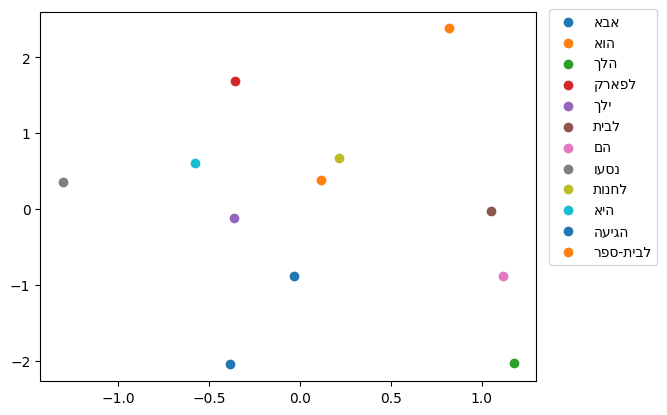

In [43]:
import matplotlib.pyplot as plt 
fig,axis = plt.subplots(1)
for word in dictionary.get_stoi():
    word_token = torch.tensor(dictionary([word]))
    word_vector = embedding(word_token).detach()[0]
    axis.scatter(*word_vector,label= word[::-1])   # reverse the word becuase is hebrow
fig.legend(bbox_to_anchor=(1.1, 0.9))
    

<div dir="rtl" lang="he" xml:lang="he">
שכבות embedding מוכנות מכילות כבר את מילים במקום "הנכון" שלהם
נראה לדוגמה איך ניתן למצוא מילים קרובות בשיכבה שמאומנות כבר. 
נשתמש בשכבות embedding מאומנות כבר, 
קיימות כמה כאלה מובנות בתור _pytorchtext_ 
אנחנו נשתמש באחת מפוסמת שנקראת _fasttext_ 
היא תאפשר לנו לטעון מילון בעברית!!


האובייקט `vectors` מכיל 
טנסור עם היצוג הוקטורי של כל המילים. בנוסף הוא מכיל דיקשנרי שנותן לכל מילה את האינדקס שלה.

In [44]:
from torchtext.vocab import FastText
vectors = FastText(language="he",cache=".vector_cache")

<div dir="rtl" lang="he" xml:lang="he">

בשביל לקבל מושג על איך זה עובד, ניצור פונקצייה שתעבור על כל האברים במילון הוקטורי שלנו ותמצא את הוקטורים הקרובים למילה נתונה

In [45]:
def find_nig(word:str, distance:float, maxRun:int=488936):
    vec = vectors[word]
    res = []

    for new_word, ind in vectors.stoi.items(): # `vectors.stoi` is dictionary that contains all word and indxex
        new_vec = vectors.vectors[ind]         # `vectors.vectors` is tensor that contains all word in index
        if torch.norm(vec - new_vec) < distance:
            res.append(new_word)
        maxRun -= 1
        if not maxRun:
            break

    return res


In [46]:
find_nig("ישראל",4.0,100000)

[',',
 '.',
 'של',
 'גם',
 'זה',
 'ישראל',
 'אך',
 'זאת',
 'אף',
 'בישראל',
 'וכן',
 'בארץ',
 'וגם',
 'ארץ',
 'מדינת',
 'לארץ',
 'לדבריו',
 'וישראל',
 'ובארץ',
 'ישראל}}',
 'ולישראל',
 'לישראל}}',
 'ישראלס',
 'ישראלה']

<div dir="rtl" lang="he" xml:lang="he">


# מודל _Ngram_
נאמן מודל שמקבל סדרת מילים ומנסה למצוא את המילה הבאה. 
מודל כזה משערך את הטעות לפי המרחק בשכבת הembdding
ככה נרוויח שתי דברים, א - שכבת הembdding שלנו תתאמן עוד, ותקרב בצורה יותר נכונה עוד מילים. 
ב - חיזו המילים ישתפר. כי מילים קרובות יראו קרובות יותר אחת לשניה. 

https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html - לבצע

https://stats.stackexchange.com/questions/324992/how-the-embedding-layer-is-trained-in-keras-embedding-layer

http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/

https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work/305032#305032

https://pytorch.org/docs/master/generated/torch.nn.EmbeddingBag.html#torch.nn.EmbeddingBag

https://pytorch.org/docs/master/generated/torch.nn.Embedding.html#torch.nn.Embedding

In [ ]:
import torch
import torchtext
from torch import nn

import plotly.graph_objects as go

from typing import List,Tuple,Dict

In [6]:
CONTEXT_SIZE = 4
EMBEDDING_DIM = 10
# We will use Shakespeare Sonnet 2
test_sentence = """When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty's field,
Thy youth's proud livery so gazed on now,
Will be a totter'd weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv'd thy beauty's use,
If thou couldst answer 'This fair child of mine
Shall sum my count, and make my old excuse,'
Proving his beauty by succession thine!
This were to be new made when thou art old,
And see thy blood warm when thou feel'st it cold.""".split()
# we should tokenize the input, but we will ignore that for now
# build a list of tuples.
# Each tuple is ([ word_i-CONTEXT_SIZE, ..., word_i-1 ], target word)
ngrams = [
    (
        [test_sentence[i - j - 1] for j in range(CONTEXT_SIZE)],
        test_sentence[i]
    )
    for i in range(CONTEXT_SIZE, len(test_sentence))
]
# Print the first 3, just so you can see what they look like.
print(ngrams[:3])


[(['shall', 'winters', 'forty', 'When'], 'besiege'), (['besiege', 'shall', 'winters', 'forty'], 'thy'), (['thy', 'besiege', 'shall', 'winters'], 'brow,')]


In [32]:
vocab = set(test_sentence)
word_to_ind = {word:i for i, word in enumerate(vocab)}

In [33]:
class NGramLanguageModeler(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, vocab_size)
        self.log_softmax = nn.LogSoftmax(1)

    def forward_train(self, inputs: torch.Tensor):
        embeds = self.embeddings(inputs).view((1, -1))
        out = self.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = self.log_softmax(out)
        return log_probs

    def predict(self, words: List[str]) -> int:
        assert len(words) == 4, "words must be of length 4"
        with torch.no_grad():
            inputs = torch.tensor(
                [word_to_ind[word] for word in words], dtype=torch.long
            )
            out = self.forward_train(inputs)
        return int(torch.argmax(out))


In [34]:
model = NGramLanguageModeler(1,10,2)
print(model.modules)
print(model.children)
print(model.parameters)



<bound method Module.modules of NGramLanguageModeler(
  (embeddings): Embedding(1, 10)
  (linear1): Linear(in_features=20, out_features=128, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)>
<bound method Module.children of NGramLanguageModeler(
  (embeddings): Embedding(1, 10)
  (linear1): Linear(in_features=20, out_features=128, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)>
<bound method Module.parameters of NGramLanguageModeler(
  (embeddings): Embedding(1, 10)
  (linear1): Linear(in_features=20, out_features=128, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=128, out_features=1, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)>


In [35]:


losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.1)

for epoch in range(10):
    total_loss = 0
    for context, target in ngrams:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ind[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ind[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

# To get the embedding of a particular word, e.g. "beauty"
print(model.embeddings.weight[word_to_ind["beauty"]])

[538.4740118980408, 351.91944685578346, 139.9541937392205, 21.9409946273081, 3.9134141968679614, 1.9619423691765405, 1.512881498085335, 1.2487707225664053, 1.066233745077625, 0.931489145179512]
tensor([ 1.3582,  0.2131, -0.3175, -1.0083,  0.1859, -1.9306,  1.7715, -2.4912,
         0.6603,  0.4291], grad_fn=<SelectBackward0>)


In [39]:
print(model.forward((torch.tensor([word_to_ind["beauty"]],dtype=torch.long))))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x10 and 40x128)

In [23]:

import timeit
def foo(count):
    while True:
        if count ==0:
            break
        count =-1

def boo(count):
    while True:
        if not count:
            break
        count -=1

import plotly.graph_objects as go
RUN_TIME = 100
res = torch.empty(RUN_TIME)
for i in range(RUN_TIME):
    res[i] = timeit.timeit("boo(10^10)", globals=globals()) - timeit.timeit(
        "foo(10^10)", globals=globals()
    )
fig  = go.Figure()
fig.add_trace(go.Scatter(x=list(range(RUN_TIME)),y=res))
print(res.mean())
fig.show()



    


tensor(-0.0283)
